In [1]:
import numpy as np
import sys
sys.path.append('../')
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from src.Mondrian_forest import *
from sklearn.metrics import mean_squared_error

dim_in = 5
active = 3
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 1000
rotation = special_ortho_group.rvs(dim_in)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(1000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)

sample_range = [n]

In [2]:
M = 10                      # number of Mondrian trees to use
delta = 0.1              # ridge regression delta

In [3]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_train, rotation)
from numpy import linalg
from src.Mondrian_matrix_utils import two_one_norm
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n
true_H = true_H / two_one_norm(true_H)

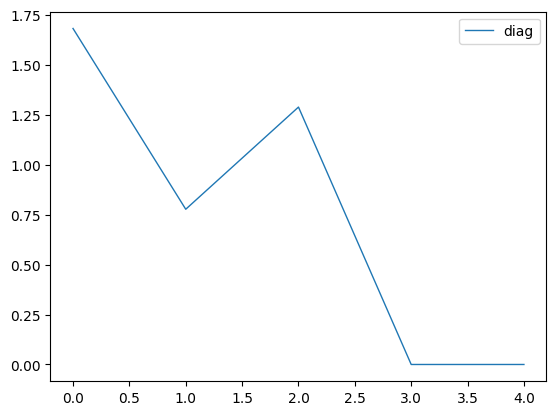

In [4]:
eigenvalues, eigenvectors = linalg.eig(true_H)
from src.Mondrian_matrix_utils import draw
draw(dim_in, eigenvalues)

In [5]:
def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    _, eigenvectors = linalg.eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    Q_t, _ = linalg.qr(truth[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    return np.arccos(S)

In [6]:
for n_sim in sample_range:
    for lifetime in [1,2,3,4,5]:
        for round in range(2):
            print(f"n_sim: {n_sim}, lifetime: {lifetime}")
            mse_best = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime, delta, H = true_H)
            print(mse_best)

n_sim: 1000, lifetime: 1


KeyboardInterrupt: 

In [ ]:
for n_sim in sample_range:
    for lifetime in [1,2,3,4,5]:
        print(f"n_sim: {n_sim}, lifetime: {lifetime}")
        mse, _, _, _, _, _ = train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime, delta)
        print(mse)

n_sim: 1000, lifetime: 1
0.9080222
n_sim: 1000, lifetime: 2
0.82342094
n_sim: 1000, lifetime: 3
0.7696853
n_sim: 1000, lifetime: 4
0.76420474
n_sim: 1000, lifetime: 5
0.77339387


In [ ]:
stats = {}
lifetime_max = 3
iterations = 8
decrement = 0
beam_width = 3
for n_sim in sample_range:
    stats[n_sim] = []
    #print(f"number of training samples: {n_sim}")
    for index in range(5):
        explore = []
        exploit = []
        results = {'full': [], 'partial': []}
        mse, X_bd_all, X, history, w_trees, y_hat_train = train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)

        exploit.append((np.identity(dim_in), mse, lifetime_max))
        H_0 = estimate_H(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, X, history, w_trees, y_hat_train)
        H_0 = H_0 / two_one_norm(H_0)
        #print(f"mse before:{mse:.5f}")
        #print("full")
        results['full'].append(mse)
        x_train_transformed, x_test_transformed = transform_data(H_0, x_train[:n_sim, ], x_test)
        lifetime = lifetime_max
        explore.append(H_0)
        for reiterate in range(iterations):

            lifetime -= decrement
            new_beam = exploit.copy()

            for H in explore:
                x_train_transformed, x_test_transformed = transform_data(H, x_train[:n_sim, ], x_test)
                mse_temp, _, _, _, _, _ = train_and_evaluate(x_train_transformed, y_train[:n_sim], 
                                                                x_test_transformed, y_test, M, lifetime, delta)
                new_beam.append((H, mse_temp, lifetime))
            explore = []

            #print(get_angle_distance(H, true_H))
            for H, mse, _ in exploit:
                x_train_transformed, x_test_transformed = transform_data(H, x_train[:n_sim, ], x_test)
                for round in range(beam_width):
                    mse_temp, H_temp = experiment(x_train_transformed, y_train[:n_sim],
                                                x_test_transformed, y_test, M, lifetime, delta, H)
                    new_beam.append((H, mse_temp, lifetime))
                    explore.append(H_temp)

            new_beam.sort(key=lambda x: x[1])
            exploit = new_beam[:beam_width]
            
            mse = exploit[0][1]
            #print(f'mse: {exploit[0][1]:.5f}, lifetime: {exploit[0][2]:.2f}')
            results['full'].append(mse)
        stats[n_sim].append(results)

In [ ]:
begin_mse, _, _, _, _, _ = train_and_evaluate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
mse_sub_best = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta, H = true_H)
mse_best_1 = simulate_proj_H(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, 1, delta, H = true_H)

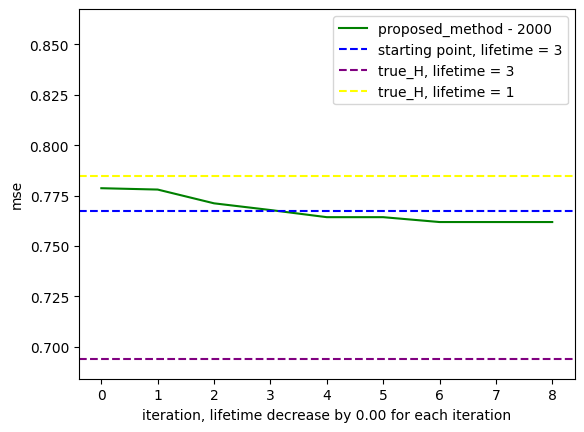

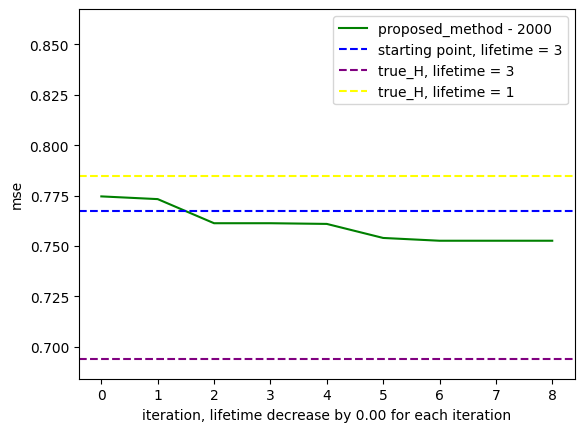

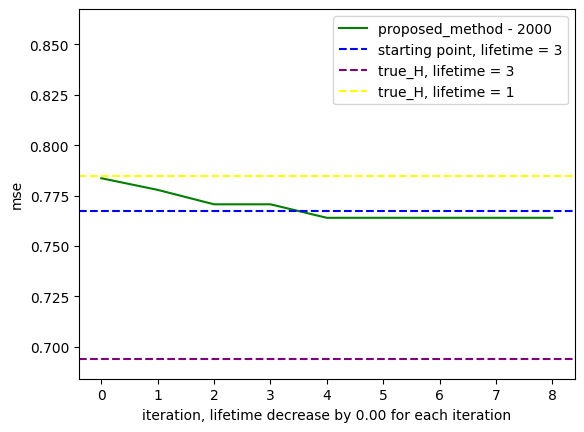

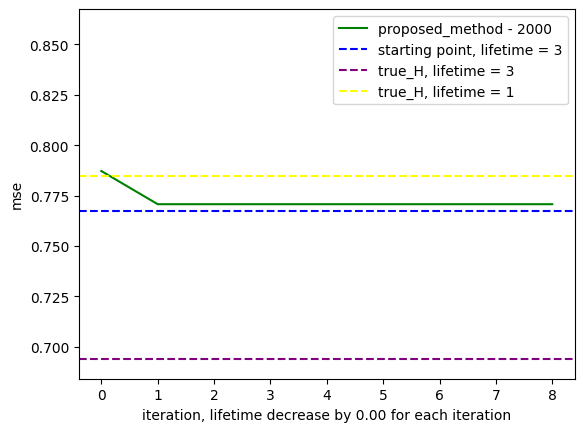

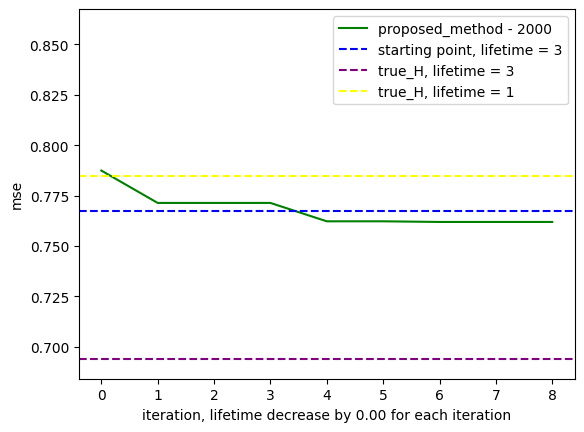

In [ ]:
x = list(range(iterations + 1))

for tries in range(5):
    fig, ax = plt.subplots()
    ax.set_ylim(mse_sub_best-0.01, begin_mse+0.1)  # 
    ax.plot(x, stats[1000][tries]['full'], color='g', label='proposed_method - 2000')
    ax.axhline(y=begin_mse, color='b', linestyle='--', label=f'starting point, lifetime = {lifetime_max}')
    ax.axhline(y=mse_sub_best, color='purple', linestyle='--', label=f'true_H, lifetime = {lifetime_max}')
    ax.axhline(y=mse_best_1, color='yellow', linestyle='--', label='true_H, lifetime = 1')
    ax.set_xlabel(f"iteration, lifetime decrease by {decrement:.2f} for each iteration")
    ax.set_ylabel("mse")
    ax.legend()